In [1]:
import torch
import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import yaml
import argparse
import copy
from diffusion_model import Model 
import torchvision.utils as tvu
import shutil
import imageio
import matplotlib

In [2]:
def forward_unet(latent, t_steps, start_step, end_step, stochastic=False, feature_map=True):
    
    if stochastic:
        S_churn=5
        S_min=0
        S_max=float('inf')
        S_noise=1.003
        
    else:
        S_churn=0
        S_min=0
        S_max=float('inf')
        S_noise=1
    
    # denoising from latent_step to feature step
    t_steps_n2f = t_steps[start_step-1:end_step+1]
    x_next = [latent]
    for i, (t_cur, t_next) in enumerate(zip(t_steps_n2f[:-1], t_steps_n2f[1:])): # 0, ..., N-1

        t_cur = torch.ones(x_next[0].shape[0], device=t_cur.device) * t_cur
        t_next = torch.ones(x_next[0].shape[0], device=t_next.device) * t_next

        x_cur = x_next[-1]

        # Increase noise temporarily.
        gamma = min(S_churn / args.timesteps, np.sqrt(2) - 1) if S_min <= t_cur[0] <= S_max else 0
        t_hat = torch.as_tensor(t_cur + gamma * t_cur)
        x_hat = (x_cur + (t_hat[0] ** 2 - t_cur[0] ** 2).sqrt() * S_noise * torch.randn_like(x_cur))
        
        for param in model.parameters():
            param.requires_grad = False
        denoised, features = model(x_hat, t_hat, return_intermediates = True)
        d_cur = (x_hat - denoised) / t_hat[0]
        x_next_ = x_hat + (t_next[0] - t_hat[0]) * d_cur

        # Apply 2nd order correction.
        if end_step != args.timesteps or i < end_step - start_step - 1:
            denoised = model(x_next_, t_next)
            d_prime = (x_next_ - denoised) / t_next[0]
            x_next_ = x_hat + (t_next[0] - t_hat[0]) * (0.5 * d_cur + 0.5 * d_prime)
        x_next.append(x_next_)
    if feature_map:
        return x_next[-1], features
    else:
        return x_next[-1]
    
def check_handle_reach_target(handle_points, target_points):
    all_dist = list(map(lambda p,q: (torch.tensor(p).float()-torch.tensor(q).float()).norm(), handle_points, target_points))
    return (torch.tensor(all_dist) < 1.0).all()

def interpolate_feature_patch(feat, y, x, r):
    x0 = torch.floor(x).long()
    x1 = x0 + 1

    y0 = torch.floor(y).long()
    y1 = y0 + 1

    wa = (x1.float() - x) * (y1.float() - y)
    wb = (x1.float() - x) * (y - y0.float())
    wc = (x - x0.float()) * (y1.float() - y)
    wd = (x - x0.float()) * (y - y0.float())

    Ia = feat[:, :, y0-r : y0+r+1, x0-r : x0+r+1]
    Ib = feat[:, :, y1-r:y1+r+1, x0-r:x0+r+1]
    Ic = feat[:, :, y0-r:y0+r+1, x1-r:x1+r+1]
    Id = feat[:, :, y1-r:y1+r+1, x1-r:x1+r+1]

    return Ia * wa + Ib * wb + Ic * wc + Id * wd

In [3]:
def point_tracking(F0, F1, handle_points, handle_points_init, args):   
    def get_neighbor_patch(_F, _p, r_n):
        with torch.no_grad():
            # r_n defines the local neighbor radius to tracking point, default as 5.
            r_n1, r_n2 = int(_p[0])-r_n, int(_p[0])+r_n+1
            c_n1, c_n2 = int(_p[1])-r_n, int(_p[1])+r_n+1

            neighbor_patch = _F[:, :, r_n1:r_n2, c_n1:c_n2]
        return neighbor_patch

    r_trackin_patch = 4
    with torch.no_grad():
        for i in range(len(handle_points)):
            pi0, pi = handle_points_init[i], handle_points[i]
            
            # r_p defines the radius where we search the point, default as 10.
            r1, r2 = int(pi[0])-args.r_p, int(pi[0])+args.r_p+1
            c1, c2 = int(pi[1])-args.r_p, int(pi[1])+args.r_p+1
            
            patch_init = get_neighbor_patch(F0, pi0, r_trackin_patch)
            
            '''tracking through patch value'''
#             all_dist = torch.zeros([r2-r1, c2-c1])
#             for _r in range(0, r2-r1):
#                 for _c in range(0, c2-c1):
# #                     _dist = (patch_init - get_neighbor_patch(F1, [_x+r1, _y+c1], args.r_n)).abs().sum()
#                     _dist = (patch_init - get_neighbor_patch(F1, [_r+r1, _c+c1], r_trackin_patch)).abs().sum()
#                     all_dist[_r, _c] = _dist
            
            '''tracking through point value'''
            F1_neighbor = F1[:, :, r1:r2, c1:c2]
            f0 = F0[:, :, int(pi0[0]), int(pi0[1])]
            all_dist = (f0.unsqueeze(dim=-1).unsqueeze(dim=-1) - F1_neighbor).abs().sum(dim=1)
            
            
            # WARNING: no boundary protection right now
            row, col = divmod(all_dist.argmin().item(), all_dist.shape[-1])
            handle_points[i][0] = pi[0] - args.r_p + row
            handle_points[i][1] = pi[1] - args.r_p + col
        return handle_points

In [99]:
def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

torch.set_printoptions(sci_mode=False)
args = {
    'config': 'biked_256.yml',
    'seed': 1234,
    'exp': 'result_diffusion_model',
    'doc': 'log_folder',
    'comment': "",
    'verbose': "info",
    'sequence': False,
    'test': True,
    'sample': False,
    'fid': False,
    'interpolation': False,
    'resume_training': False,
    'image_folder': "result_diffusion_model/images",
    'generated_image_folder': "dragging_process_4",
    'ni': False,
    'use_pretrained': False,
    'sample_type': "stochastic",
#     deterministic, stochastic
    'timesteps': 18,
    'eta': 0.0,
    'dataparallel': [0],
    'ckpt_id': '109000',
    'r_p': 5,
    'r_n': 5,
    'lam': 1,
    'latent_step': 3,
    'feature_step' : 10,
    'sigma_start' : 5.3,
    'sigma_end' : 0.6,
    'rho' : 7,
    'test_img_nr':5,
}

args['log_path']=os.path.join(args['exp'], "logs", args['doc'])
args = dict2namespace(args)
with open(args.config, "r") as f:
    config = yaml.safe_load(f)
config['tb_logger'] = None
config = dict2namespace(config)
tb_path = os.path.join(args.exp, "tensorboard", args.doc)

(1000, 256, 256, 1)
(1000, 256, 256, 1)
test_images data range: { -1.0 ~ 1.0 }


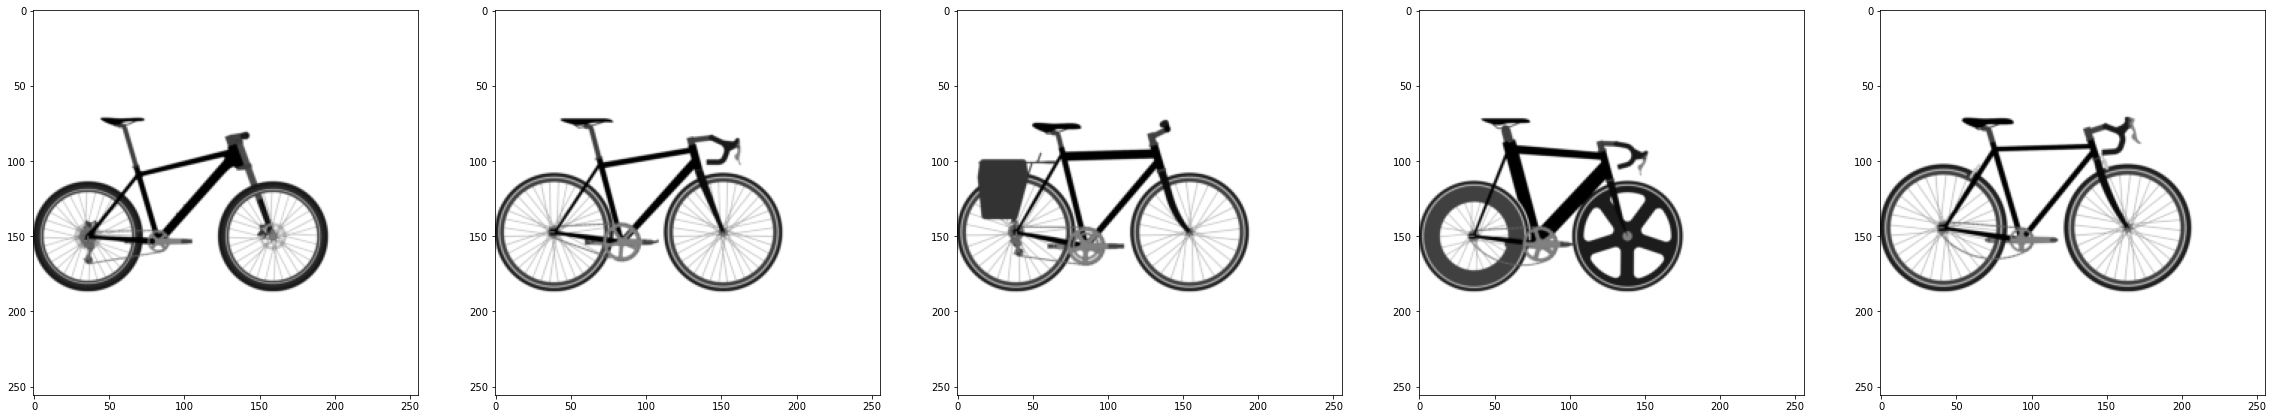

In [100]:
test_images = np.load('/home/q603750/q603750/00_Datasets/BIKED Dataset/biked_test_256.npy', mmap_mode='r')
print(test_images.shape)
test_images = test_images/0.5-1
print(test_images.shape)
print("test_images data range: {", test_images[:100].min(),"~",test_images[:100].max(),"}")
test_images_tensor = torch.tensor(test_images)
test_images_tensor = test_images_tensor.permute((0,3, 1, 2))
plotting_images = test_images
del test_images

plt.figure(figsize=(40, 200))
plt.subplot(1, 5, 1)
plt.imshow(plotting_images[0, :, :, 0], cmap='gray')
plt.subplot(1, 5, 2)
plt.imshow(plotting_images[5, :, :, 0], cmap='gray')
plt.subplot(1, 5, 3)
plt.imshow(plotting_images[6, :, :, 0], cmap='gray')
plt.subplot(1, 5, 4)
plt.imshow(plotting_images[7, :, :, 0], cmap='gray')
plt.subplot(1, 5, 5)
plt.imshow(plotting_images[8, :, :, 0], cmap='gray')

test_img = plotting_images[args.test_img_nr:args.test_img_nr+1, :, :,:]
test_img = torch.tensor(test_img)
test_img = test_img.permute((0, 3, 1, 2))
del plotting_images, test_images_tensor

In [101]:
# torch_device = "cuda:" + str(args.dataparallel[0])
torch_device = "cuda:" + str(args.dataparallel[0])
device = torch.device(torch_device) if torch.cuda.is_available() else torch.device("cpu")
print("Using device: {}".format(device))
config.device = device

# set random seed
torch.manual_seed(args.seed)
np.random.seed(args.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(args.seed)

torch.backends.cudnn.benchmark = True

Using device: cuda:0


In [102]:
model = Model(config)
states = torch.load(
    os.path.join(
        args.log_path, f"ckpt_{args.ckpt_id}.pth"
    ),
    map_location=config.device,
)
print('load ckpt: ', args.ckpt_id)
model = model.to(device)
model = torch.nn.DataParallel(model, args.dataparallel)
model.load_state_dict(states[0], strict=True)
print('load epoch: ', states[3])
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model.eval()

print(f"Number of parameters in the model: {total_params}")

load ckpt:  109000
load epoch:  109000
Number of parameters in the model: 9361729


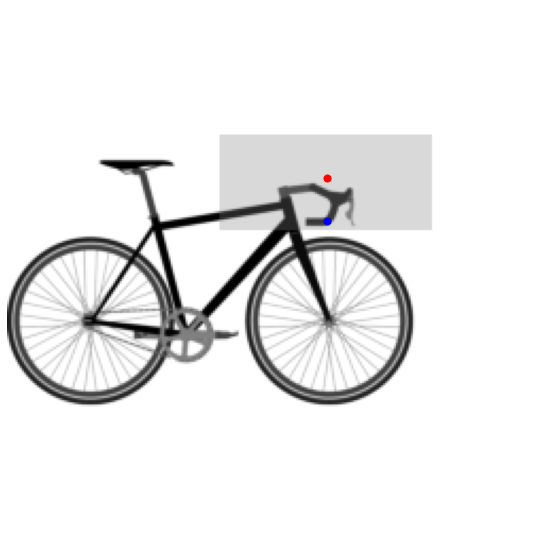

In [103]:
"""Define the masked area"""
mask = torch.ones((1, config.data.image_size, config.data.image_size), dtype = torch.float32, device=device)
x_1 = 100
x_2 = 200
y_1 = 60
y_2 = 105
for _x in range(x_1, x_2):
    for _y in range(y_1, y_2):
        mask[:,_y,_x] = 0.7
masked_bike = test_img[0].to(device) * mask
plt.figure(figsize=(10, 10))
plt.imshow(masked_bike.permute((1,2,0)).cpu(), cmap='gray')


handle_points_init = [[100,150]]
target_points = [[80,150]]
# handle_points_init = [[148,152],[153,84],[72,60]]
# target_points = [[148,140], [140,85],[72,60]]

for i in range(len(handle_points_init)):
    plt.scatter(handle_points_init[i][1], handle_points_init[i][0],s=50, color = 'blue')
    plt.scatter(target_points[i][1], target_points[i][0],s=50, color = 'red')
    plt.axis('off')

for _x in range(x_1, x_2):
    for _y in range(y_1, y_2):
        mask[:,_y,_x] = 0

In [104]:
# creating the latent code at latent_step 

sigma_min = args.sigma_end **2 /args.sigma_start
sigma_max = args.sigma_start **2 /args.sigma_end

step_indices = torch.arange(args.timesteps, device=device)
t_steps = (sigma_max ** (1 / args.rho) + step_indices / (args.timesteps - 1) * (sigma_min ** (1 / args.rho) - sigma_max ** (1 / args.rho))) ** args.rho
t_steps = torch.cat([torch.as_tensor(t_steps), torch.zeros_like(t_steps[:1])])
t_steps_flip = t_steps.flip(0)

init_code = test_img.to(device)

for i, (t_cur, t_next) in enumerate(zip(t_steps_flip[:-args.latent_step], t_steps_flip[1:-args.latent_step+1])):
    init_code = init_code + (t_next-t_cur) * torch.randn_like(init_code)
#     if i == args.timesteps - args.feature_step +1:        
#         real_features = copy.deepcopy(init_code)

init_code_0 = copy.deepcopy(init_code)

# plt.figure(figsize=(5, 5))
# for i in range(len(handle_points_init)):
#     plt.scatter(handle_points_init[i][1], handle_points_init[i][0],s=100, color = 'blue')
#     plt.scatter(target_points[i][1], target_points[i][0],s=100, color = 'red')
# plt.axis('off')
# plt.imshow(init_code.permute((0, 2, 3, 1))[0].cpu(), cmap='gray')

t_steps_flip[:-args.latent_step+1]

tensor([ 0.0000,  0.0679,  0.1248,  0.2185,  0.3668,  0.5944,  0.9335,  1.4265,
         2.1277,  3.1058,  4.4465,  6.2554,  8.6617, 11.8214, 15.9216, 21.1850,
        27.8745], device='cuda:0')

In [108]:
# shutil.rmtree(args.generated_image_folder)
os.makedirs(args.generated_image_folder)

with torch.no_grad():
    x_prev, F0 = forward_unet(latent=init_code, t_steps= t_steps, start_step=args.latent_step, end_step=args.feature_step,  stochastic=False, feature_map=True)
# F0 = x_prev
# prepare optimizable init_code and optimizer
init_code.requires_grad_(True)
optimizer = torch.optim.Adam([init_code], lr=0.01)

# prepare for point tracking and background regularization
handle_points = copy.deepcopy(handle_points_init)

print(F0.size())
print(f"target_points: {target_points}, handle_points: {handle_points}.")

n_pix_step = 200
image_steps = []
loss = torch.tensor(0.0)
# prepare amp scaler for mixed-precision training
scaler = torch.cuda.amp.GradScaler()
_steps = tqdm.tqdm(range(n_pix_step), desc=f"start", leave = False)
for step_idx in _steps:
    with torch.cuda.amp.autocast():
        x_prev_updated, F1 = forward_unet(latent=init_code, t_steps= t_steps, start_step=args.latent_step, end_step=args.feature_step, stochastic=False, feature_map=True)
        # do point tracking to update handle points before computing motion supervision loss
        if step_idx != 0:
            handle_points = point_tracking(F0, F1, handle_points, handle_points_init, args)
            _steps.set_description(f"handle_points: {handle_points}, loss: {loss.item()}")

        # break if all handle points have reached the targets
        if check_handle_reach_target(handle_points, target_points):
            break

        loss = 0.0
        for i in range(len(handle_points)):

            pi, ti = torch.tensor(handle_points[i]).float(), torch.tensor(target_points[i]).float()
            # skip if the distance between target and source is less than 1
            if (ti - pi).norm() < 2:
                continue

            di = (ti - pi) / (ti - pi).norm()
            # motion supervision
#             F1 = x_prev_updated
            f0_patch = F1[:,:,int(pi[0])-args.r_n:int(pi[0])+args.r_n+1, int(pi[1])-args.r_n:int(pi[1])+args.r_n+1].detach()
#             f1_patch = F1[:,:,int(pi[0]+ di[0])-args.r_n:int(pi[0]+ di[0])+args.r_n+1, int(pi[1] + di[1])-args.r_n:int(pi[1] + di[1])+args.r_n+1]
            f1_patch = interpolate_feature_patch(F1, pi[0] + di[0], pi[1] + di[1], args.r_n)
            loss += ((2*args.r_n+1)**2) * (f0_patch- f1_patch).abs().mean()
        
#             if step_idx == 0:
#                 x0_patch_init = real_features[:,:,int(pi[0])-args.r_n:int(pi[0])+args.r_n+1, int(pi[1])-args.r_n:int(pi[1])+args.r_n+1].detach()
#             x1_patch = interpolate_feature_patch(x_prev_updated, pi[0] + di[0], pi[1] + di[1], args.r_n)
#             loss += ((args.r_n)**2) * (x0_patch_init- x1_patch).abs().mean()
        
        # masked region must stay unchanged
        loss += args.lam * ((x_prev_updated-x_prev)*mask).abs().mean()
#         loss += 0.1 * torch.nn.functional.kl_div(init_code, t_steps[args.latent_step-1] * torch.randn_like(init_code))
        _steps.set_description(f"handle_points: {handle_points}, loss: {loss.item()}")

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    optimizer.zero_grad()
    
    with torch.no_grad():
        x_plot = forward_unet(latent=init_code, t_steps= t_steps, start_step=args.latent_step, end_step=args.timesteps, feature_map=False)
    x_plot = (x_plot + 1)/2
    tvu.save_image(x_plot, os.path.join(args.generated_image_folder, f"{step_idx}.png"))

torch.Size([1, 128, 256, 256])
target_points: [[80, 150]], handle_points: [[100, 150]].


200


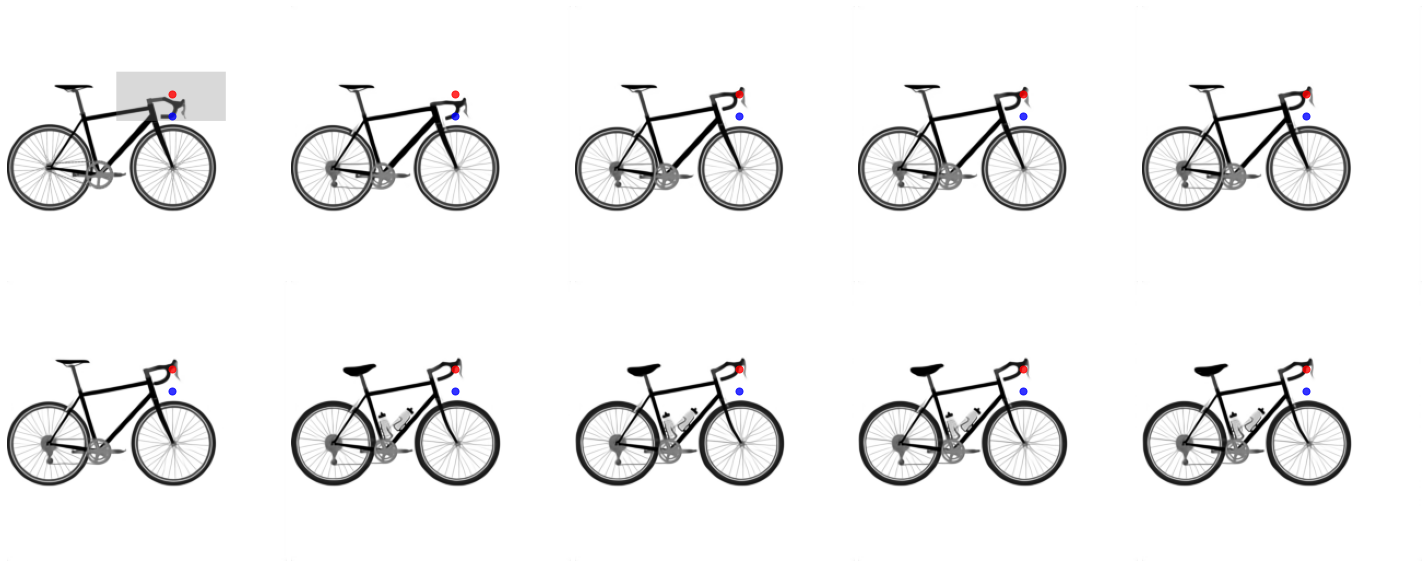

In [110]:
images = []
images_path = "/home/q603750/q603750/01_Finished_trainings/FDM_biked_256_standard/" + args.generated_image_folder
filenames = os.listdir(images_path)
k = 1
for filename in range(200):
    try:
        filepath = images_path + '/' + str(filename) + ".png"
        images.append(matplotlib.image.imread(filepath))
    except:
        break
    k += 1
print(len(images))
s_size = 50
images = np.asarray(images)
plt.figure(figsize=(20, 8))

plt.subplot(2, 5, 1)
for i in range(len(handle_points_init)):
    plt.scatter(handle_points_init[i][1], handle_points_init[i][0],s=s_size, color = 'blue',alpha = 0.8)
    plt.scatter(target_points[i][1], target_points[i][0],s=s_size, color = 'red',alpha = 0.8)
# masked_bike = test_img[0].to(device) * mask
# plt.imshow(test_img[0].permute((1,2,0)).cpu(), cmap='gray')
plt.imshow(masked_bike.permute((1,2,0)).cpu(), cmap='gray')
plt.axis('off')

for drag_nr in range(4):
    plt.subplot(2, 5, drag_nr+2)
    for i in range(len(handle_points_init)):
        plt.scatter(handle_points_init[i][1], handle_points_init[i][0],s=s_size, color = 'blue',alpha = 0.8)
#         plt.scatter(handle_points[i][1], handle_points[i][0],s=s_size, color = 'blue',alpha = 0.8)
        plt.scatter(target_points[i][1], target_points[i][0],s=s_size, color = 'red',alpha = 0.8)

#     plt.imshow(test_img[0].permute((1,2,0)).cpu(), cmap='gray', alpha = 0.2)
    plt.imshow(images[20 * drag_nr + 39], cmap='gray')
    plt.axis('off')

for drag_nr in range(5):
    plt.subplot(2, 5, drag_nr+6)
    for i in range(len(handle_points_init)):
        plt.scatter(handle_points_init[i][1], handle_points_init[i][0],s=s_size, color = 'blue',alpha = 0.8)
#         plt.scatter(handle_points[i][1], handle_points[i][0],s=s_size, color = 'blue',alpha = 0.8)
        plt.scatter(target_points[i][1], target_points[i][0],s=s_size, color = 'red',alpha = 0.8)

#     plt.imshow(test_img[0].permute((1,2,0)).cpu(), cmap='gray', alpha = 0.2)
    plt.imshow(images[20 * drag_nr + 119], cmap='gray')
    plt.axis('off')
    
plt.tight_layout(h_pad=0, w_pad=0)
plt.savefig(args.generated_image_folder+'.png', bbox_inches='tight')
# plt.save(args.generated_image_folder+'.png')

200


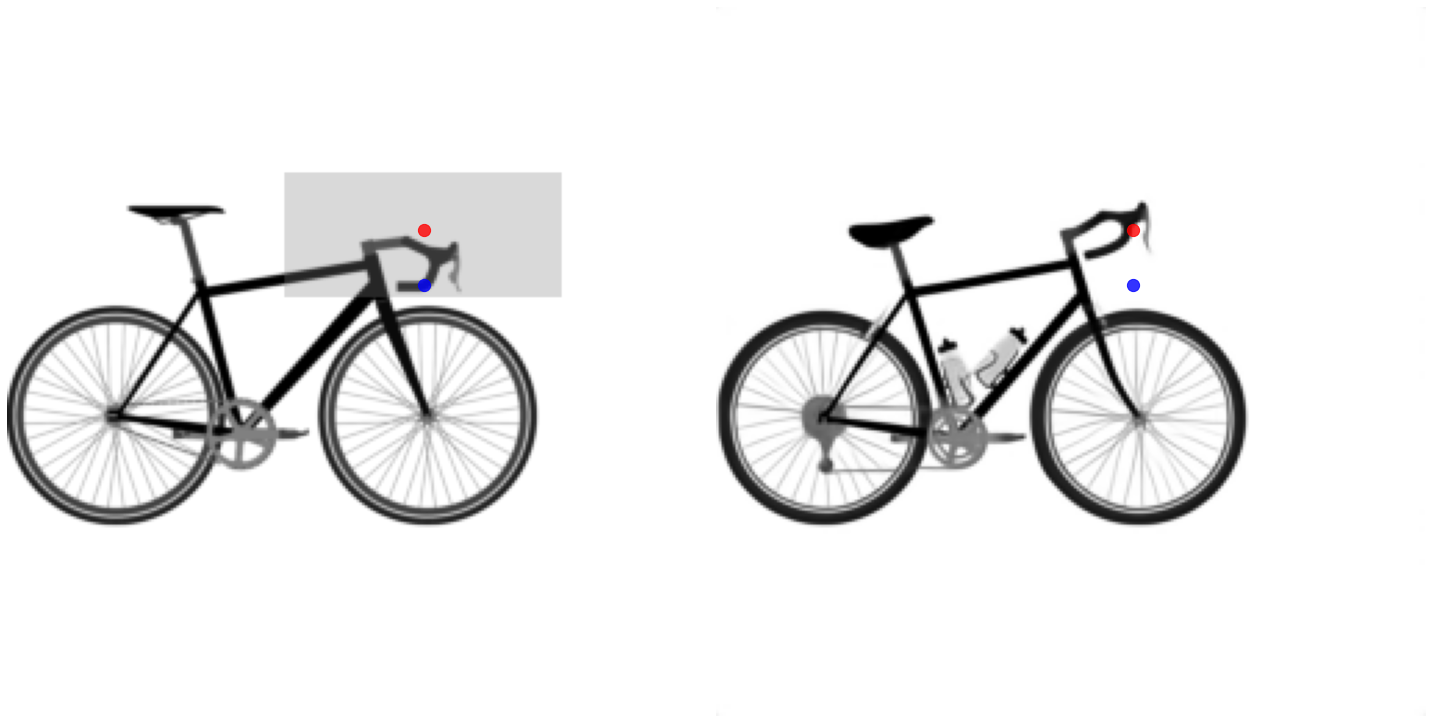

In [112]:
images = []
images_path = "/home/q603750/q603750/01_Finished_trainings/FDM_biked_256_standard/" + args.generated_image_folder
filenames = os.listdir(images_path)
k = 1
for filename in range(200):
    try:
        filepath = images_path + '/' + str(filename) + ".png"
        images.append(matplotlib.image.imread(filepath))
    except:
        break
    k += 1
print(len(images))
s_size = 150
images = np.asarray(images)
plt.figure(figsize=(20, 15))

plt.subplot(1, 2, 1)
for i in range(len(handle_points_init)):
    plt.scatter(handle_points_init[i][1], handle_points_init[i][0],s=s_size, color = 'blue',alpha = 0.8)
    plt.scatter(target_points[i][1], target_points[i][0],s=s_size, color = 'red',alpha = 0.8)
# masked_bike = test_img[0].to(device) * mask
# plt.imshow(test_img[0].permute((1,2,0)).cpu(), cmap='gray')
plt.imshow(masked_bike.permute((1,2,0)).cpu(), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
for i in range(len(handle_points_init)):
    plt.scatter(handle_points_init[i][1], handle_points_init[i][0],s=s_size, color = 'blue',alpha = 0.8)
#     plt.scatter(handle_points[i][1], handle_points[i][0],s=s_size, color = 'blue',alpha = 0.8)
    plt.scatter(target_points[i][1], target_points[i][0],s=s_size, color = 'red',alpha = 0.8)

#     plt.imshow(test_img[0].permute((1,2,0)).cpu(), cmap='gray', alpha = 0.2)
plt.imshow(images[-10], cmap='gray')
plt.axis('off')

plt.tight_layout(h_pad=0, w_pad=0)
# plt.savefig(args.generated_image_folder+'.png', bbox_inches='tight')

plt.figure(figsize=(10, 10))
with torch.no_grad():
    for i in range(len(handle_points_init)):
        plt.scatter(handle_points_init[i][1], handle_points_init[i][0],s=50, color = 'lightseelblue')
        plt.scatter(handle_points[i][1], handle_points[i][0],s=50, color = 'blue')
        plt.scatter(target_points[i][1], target_points[i][0],s=50, color = 'red')

    plt.imshow(forward_unet(latent=x_prev_updated, t_steps= t_steps, start_step=args.feature_step, end_step=args.timesteps, feature_map=False)[0].permute((1,2,0)).cpu(), cmap='gray')
    plt.axis('off')

In [12]:
images = []
# result_path = 'Result_WGan-GP_0404'
# images_path = result_path + '/Images'
images_path = "/home/q603750/q603750/01_Finished_trainings/FDM_biked_256_standard/" + args.generated_image_folder
filenames = os.listdir(images_path)
k = 1
for filename in range(100):
#     if filename%2==0:
    try:
        filepath = images_path + '/' + str(filename) + ".png"
        images.append(matplotlib.image.imread(filepath))
    except:
        break
    k += 1
print(len(images))

images = np.asarray(images)

save_path = '/home/q603750/q603750/01_Finished_trainings/FDM_biked_256_standard' + '/DragFDM_Biked.gif'
# save_path ='BP_horizontal.gif'
imageio.mimsave(save_path, images, duration=0.05)
print('done')

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

100


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

done


In [13]:
filepath

'/home/q603750/q603750/01_Finished_trainings/FDM_biked_256_standard/dragging_process_2/99.png'

In [14]:
filepath

'/home/q603750/q603750/01_Finished_trainings/FDM_biked_256_standard/dragging_process_2/99.png'